# Intro

This is my second Kaggle kernel. I will show some analysis functions, and then concentrate on developing new functions, which then will probably help to achieve a good result. The last part deals with modeling and comparing various models.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve, cross_val_score

In [2]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")
testid = test['PassengerId']
train_len = len(train)

y = train['Survived']
X = pd.concat([train, test])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


# Outliers: profit or not?

Since outliers can have a significant impact on the forecast, I decided to find them, remove and compare the results with them and without them. I used numerical values (Age, SibSp, Sarch and Fare).

The function ***graphics*** is responsible for the search for outliers and the function ***remove_outlier*** is for the removal.

**Spoiler:** results without outliers got worse. So in the problems of classification with this it is worth being very careful.

In [3]:
def remove_outlier(df_in, col_name):
    
    mean = df_in[col_name].mean()
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    for ind in range(120):
        if (df_in[col_name].iloc[ind]>fence_high) or (df_in[col_name].iloc[ind]<fence_low):
            df_in[col_name].iloc[ind] = mean
            
    return df_in[col_name]

def graphics(df, y, features):
    for ind in features:
        plt.boxplot(x=df[ind], vert=False)
        plt.grid(True)
        plt.title(ind + " boxplot")
        plt.xlabel(ind+' value')
        plt.ylabel('Survived')
        plt.show()


#graphics(train, y, ["Pclass","SibSp","Fare"])

#train['Age'] = remove_outlier(train, "Age")
#train['SibSp'] = remove_outlier(train, "SibSp")
#train['Parch'] = remove_outlier(train, "Parch")
#train['Fare'] = remove_outlier(train, "Fare")

# Feature analysis



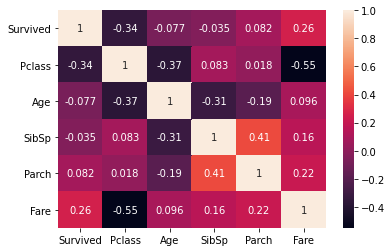

In [4]:
sns.heatmap(train[["Survived","Pclass","Age","SibSp","Parch","Fare"]].corr(), annot=True)

Only Fare feature seems to have a significative correlation with the survival probability.  It doesn't mean that the other features are not usefull. All other hidden dependencies are found on the graphs below.

**Age**

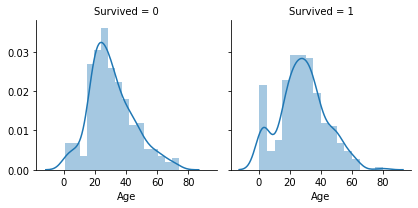

In [5]:
sns.FacetGrid(train, col='Survived').map(sns.distplot, "Age")

The age distribution is probably a Gaussian distribution. It's good.

The graphs show a peak in survival among young people. Unfortunately, elderly people have less chances to survive. A jump in survival in children is also visible, which is quite logical. Most likely they were saved in the first place.

**SibSp**

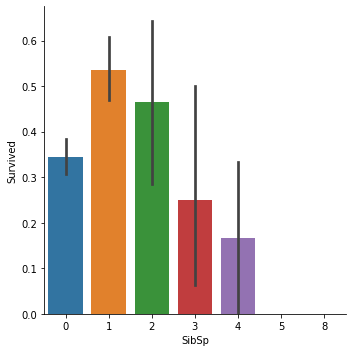

In [6]:
sns.catplot(x="SibSp", y="Survived", data=train, kind="bar")

From the graph, it can be suggested that people with fewer relatives are more likely to survive. We will return to this later and examine in more detail.

**Pclass**

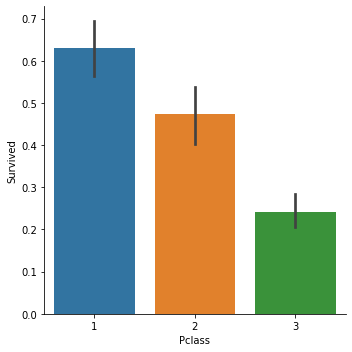

In [7]:
sns.catplot(x="Pclass", y="Survived", data=train, kind="bar")

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survive than second class and third class passengers.  

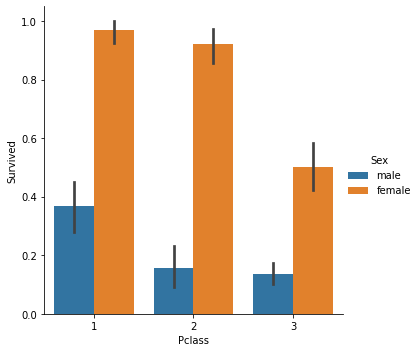

In [8]:
sns.catplot(x="Pclass", y="Survived", hue="Sex", data=train, kind="bar")

This trend is conserved when we look at both male and female passengers.

**Parch**

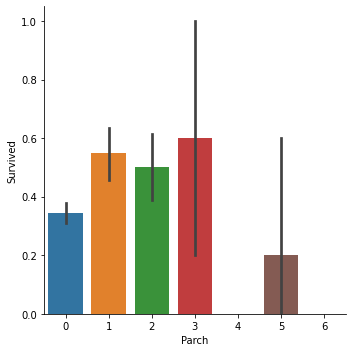

In [9]:
sns.catplot(x="Parch", y="Survived", data=train, kind="bar")

Small families have more chance to survive, more than single (Parch 0), medium (Parch 3,4) and large families (Parch 5,6). 

**Sex**

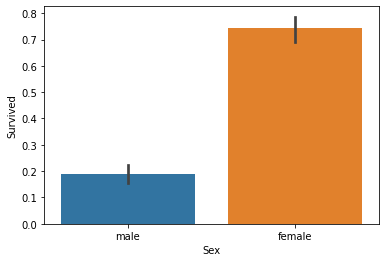

In [10]:
sns.barplot(x="Sex", y="Survived", data=train)

Men are less likely to survive than women. This is quite logical, because women were also allowed to go forward on rescue boats. Perhaps this will play a key role later.

**Embarked**

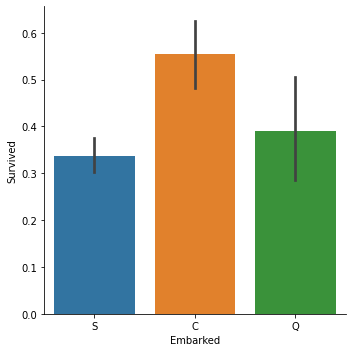

In [11]:
sns.catplot(x="Embarked", y="Survived", data=train, kind="bar")

A passenger arriving from Cherbourg (C) seems to be more likely to survive. But I think that this will not be a key function for our prediction.

# Engineering features

**Title**

I make a Title feature for imputing ages more precisely. Median is used because ages distribution is not always normal, so it's generally preferred over mean. But I don't think this matters a lot, you can use mean too. Next, I don't use Title feature for fitting models so it's discarded.

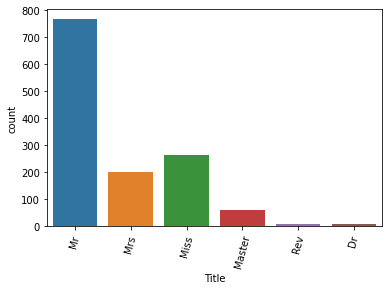

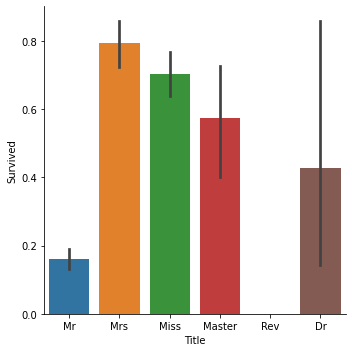

In [12]:
X['Title'] = X['Name']

for name_string in X['Name']:
    X['Title'] = X['Name'].str.extract('([A-Za-z]+)\.', expand=True)

mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
          'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}

X.replace({'Title': mapping}, inplace=True)
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']

for title in titles:
    age_to_impute = X.groupby('Title')['Age'].median()[titles.index(title)]
    X.loc[(X['Age'].isnull()) & (X['Title'] == title), 'Age'] = age_to_impute

gr = sns.countplot(x="Title",data=X)
gr.set_xticklabels(gr.get_xticklabels(), rotation=75)
plt.show(gr)
sns.catplot(x="Title",y="Survived",data=X.iloc[:train_len],kind="bar")
plt.show(sns)    

X.drop('Title', axis = 1, inplace = True)

**Family Size**

Everything is simple here)

In [13]:
X['Family_Size'] = X['Parch'] + X['SibSp']

**Family Sirvival**

This function is from the [S.Xu kernel](https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever), it groups families and people with the same tickets and explores the information. You can read in more detail in the original. Thanks to him for the work done!

**Spoiler:** this feature that helped improve the current result quite well. It is quite complicated in ideological understanding, but it is worth it.

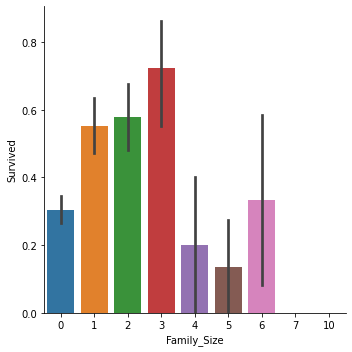

In [14]:
X['Last_Name'] = X['Name'].apply(lambda x: str.split(x, ",")[0])
X['Fare'].fillna(X['Fare'].mean(), inplace=True)

DEFAULT_SURVIVAL_VALUE = 0.5
X['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in X[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                X.loc[X['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                X.loc[X['PassengerId'] == passID, 'Family_Survival'] = 0
                
for _, grp_df in X.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    X.loc[X['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    X.loc[X['PassengerId'] == passID, 'Family_Survival'] = 0
                        

sns.catplot(x="Family_Size",y="Survived",data = X.iloc[:train_len],kind="bar")

**Fare Bin**

At first I tried get dummies, but the results were bad. Later I saw such an option in one of the kernels, implemented it and got a boost to the rating.

In [15]:
X['Fare'].fillna(X['Fare'].median(), inplace = True)

# Making Bins
X['FareBin'] = pd.qcut(X['Fare'], 5)

label = LabelEncoder()
X['FareBin_Code'] = label.fit_transform(X['FareBin'])

X.drop(['Fare'], 1, inplace=True)

**Age Bin**

*Similarly*

In [16]:
X['AgeBin'] = pd.qcut(X['Age'], 4)

label = LabelEncoder()
X['AgeBin_Code'] = label.fit_transform(X['AgeBin'])

X.drop(['Age'], 1, inplace=True)

**Mapping SEX and dropping columns**

In [17]:
X['Sex'].replace(['male','female'],[0,1],inplace=True)


X.drop(['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin',
               'Embarked', 'Last_Name', 'FareBin', 'AgeBin', 'Survived'], axis = 1, inplace = True)

# Training

**Make train and test sets**

In [18]:
X_train = X[:train_len]
X_test = X[train_len:]

y_train = y

**Scaling features**

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Classifiers

I compared several popular classifiers and estimated the average accuracy of each of them using cross-validation. For each model, I selected the parameters with the help of GridSarch.

* RandomForest
* KNeighbors
* XGB
* KNeighbors

In [20]:
kfold = StratifiedKFold(n_splits=8)

In [21]:
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
              "max_features": [3,"sqrt", "log2"],
              "min_samples_split": [2, 4],
              "min_samples_leaf": [5, 7],
              "bootstrap": [False, True],
              "n_estimators" :[200, 500],
              "criterion": ["gini", "entropy"]}

rf_param_grid_best = {"max_depth": [None],
              "max_features": [3],
              "min_samples_split": [4],
              "min_samples_leaf": [5],
              "bootstrap": [False],
              "n_estimators" :[200],
              "criterion": ["gini"]}

gs_rf = GridSearchCV(RFC, param_grid = rf_param_grid_best, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gs_rf.fit(X_train, y_train)
RFC.fit(X_train, y_train)
rf_best = gs_rf.best_estimator_
print(f'RandomForest GridSearch best params: {gs_rf.best_params_}')
print(f'RandomForest GridSearch best score: {gs_rf.best_score_}')

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    3.3s finished


RandomForest GridSearch best params: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 200}
RandomForest GridSearch best score: 0.8793351221513209


In [22]:
KNN = KNeighborsClassifier()

knn_param_grid = {'algorithm': ['auto'],
                 'weights': ['uniform', 'distance'], 
                 'leaf_size': [20, 25, 30], 
                 'n_neighbors': [12, 14, 16]}
gs_knn = GridSearchCV(KNN, param_grid = knn_param_grid, cv=kfold, scoring = "roc_auc", n_jobs= 4, verbose = 1)

gs_knn.fit(X_train, y_train)
KNN.fit(X_train, y_train)

knn_best = gs_knn.best_estimator_
print(f'KNN GridSearch best params: {gs_knn.best_params_}')
print(f'KNN GridSearch best score: {gs_knn.best_score_}')

Fitting 8 folds for each of 18 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KNN GridSearch best params: {'algorithm': 'auto', 'leaf_size': 25, 'n_neighbors': 16, 'weights': 'uniform'}
KNN GridSearch best score: 0.8754087770092869


[Parallel(n_jobs=4)]: Done 130 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed:    0.4s finished


In [23]:
GB = GradientBoostingClassifier()

gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [1000],
              'learning_rate': [0.02, 0.05],
              'min_samples_split': [15, 20, 25],
              'max_depth': [4, 6],
              'min_samples_leaf': [50, 60],
              'max_features': ["sqrt"] 
              }

gb_param_grid_best = {'loss' : ["deviance"],
              'n_estimators' : [1000],
              'learning_rate': [0.02],
              'min_samples_split': [25],
              'max_depth': [4],
              'min_samples_leaf': [60],
              'max_features': ["sqrt"] 
              }

gs_gb = GridSearchCV(GB, param_grid = gb_param_grid_best, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gs_gb.fit(X_train,y_train)
GB.fit(X_train, y_train)

gb_best = gs_gb.best_estimator_
print(f'GradienBoost GridSearch best params: {gs_gb.best_params_}')
print(f'GradienBoost GridSearch best score: {gs_gb.best_score_}')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    2.8s finished


GradienBoost GridSearch best params: {'learning_rate': 0.02, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 60, 'min_samples_split': 25, 'n_estimators': 1000}
GradienBoost GridSearch best score: 0.8874470246474053


In [24]:
XGB = XGBClassifier()

xgb_param_grid = {'learning_rate':[0.05, 0.1], 
                  'reg_lambda':[0.3, 0.5],
                  'gamma': [0.8, 1],
                  'subsample': [0.8, 1],
                  'max_depth': [2, 3],
                  'n_estimators': [200, 300]
              }

xgb_param_grid_best = {'learning_rate':[0.1], 
                  'reg_lambda':[0.3],
                  'gamma': [1],
                  'subsample': [0.8],
                  'max_depth': [2],
                  'n_estimators': [300]
              }

gs_xgb = GridSearchCV(XGB, param_grid = xgb_param_grid_best, cv=kfold, scoring="roc_auc", n_jobs= 4, verbose = 1)

gs_xgb.fit(X_train,y_train)
XGB.fit(X_train, y_train)

xgb_best = gs_xgb.best_estimator_
print(f'XGB GridSearch best params: {gs_xgb.best_params_}')
print(f'XGB GridSearch best score: {gs_xgb.best_score_}')

Fitting 8 folds for each of 1 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


XGB GridSearch best params: {'gamma': 1, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300, 'reg_lambda': 0.3, 'subsample': 0.8}
XGB GridSearch best score: 0.8920380251864818


[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    1.3s finished


*The model below turned out to be a trump card from all over my set. I borrowed it from one of my colleagues. You can play around with the parameters, maybe you can do it even better.*

In [25]:
knn1 = KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski', 
                           metric_params=None, n_jobs=1, n_neighbors=6, p=2, 
                           weights='uniform')

knn1.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=26, metric='minkowski',
                     metric_params=None, n_jobs=1, n_neighbors=6, p=2,
                     weights='uniform')

**Model Comparison**

In the course of work, there were many models with roc_auc of about 0.9-0.93, but when testing they mostly showed lower results. This does not mean that they are worse. Perhaps the dataset is not well formed.

In [26]:
def CVScore(classifiers):
    cv_score = []
    names = []
    for n_classifier in range(len(classifiers)):
        name = classifiers[n_classifier][0]
        model = classifiers[n_classifier][1]
        cv_score.append(cross_val_score(model, X_train, y_train, scoring = "roc_auc", cv = kfold, n_jobs=4))
        names.append(name)
    cv_means = []
    for cv_result in cv_score:
        cv_means.append(cv_result.mean())
        
    cv_res = pd.DataFrame({"Model":names,"CVMeans":cv_means})
    cv_res.sort_values("CVMeans", axis = 0, ascending = True, inplace = True)

    print('----------CrossVal scores---------\n', cv_res)

    
best_class = [("RandomForest", rf_best), ("GradientBoost", gb_best), ("KNN", knn_best), ("XGB", xgb_best), ("KNN new", knn1)]
def_class = [("RandomForest", RFC), ("GradientBoost", GB), ("KNN", KNN), ("XGB", XGB), ("KNN new", knn1)]

#CVScore(def_class)
CVScore(best_class)

----------CrossVal scores---------
            Model   CVMeans
4        KNN new  0.858444
2            KNN  0.875409
0   RandomForest  0.879504
1  GradientBoost  0.886859
3            XGB  0.892038


**Plot learning curves**

Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

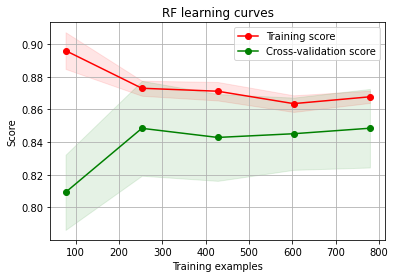

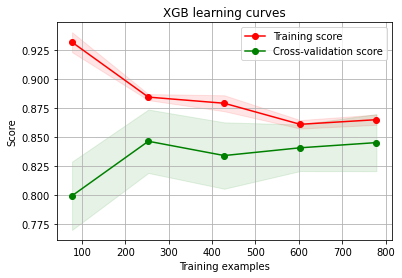

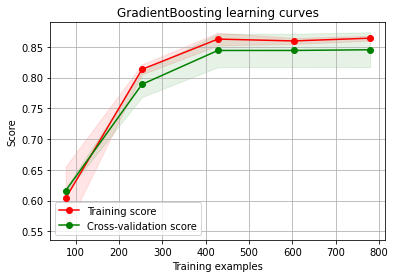

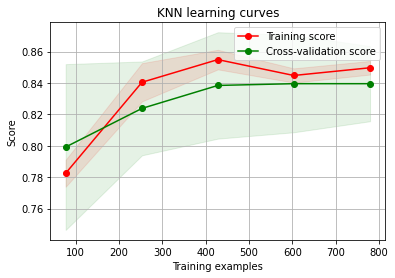

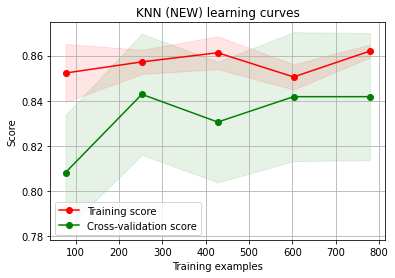

In [27]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

plot_learning_curve(rf_best,"RF learning curves", X_train, y_train, cv=kfold)
plot_learning_curve(xgb_best,"XGB learning curves", X_train, y_train, cv=kfold)
plot_learning_curve(gb_best,"GradientBoosting learning curves", X_train, y_train, cv=kfold)
plot_learning_curve(knn_best,"KNN learning curves", X_train, y_train, cv=kfold)
plot_learning_curve(knn1,"KNN (NEW) learning curves", X_train, y_train, cv=kfold)

**Making submission**

In [28]:
y_pred = knn1.predict(X_test)

test_Survived = pd.Series(y_pred, name="Survived")
results = pd.concat([testid,test_Survived],axis=1)
results.to_csv("submit.csv",index=False)

# Some conclusions:#

I speak only from my experience on the Titanic, so the following may not be true for you.

* The **Has_Cabin** function does not help. I developed a function with 0 if the passenger does not have a Cabin (NaN), and with 1 if he received.
* The **Deck** function does not help. Based on the letters found in the “Cabin” column, we can develop a “Deck” function indicating which deck (A - G, T or U for “Unknown”) was on the passenger. But it is rather noisy, it does not help the score.
* **Embarked** does not help. I tried to add it, but the results were only worse. This does not affect the chances of survival.
* Some algorithms may work better if you turn categorical functions into ordinal ones. Pluses are more accurate in some cases, minuses - you lose the connection between classes.
* Standard Scaler is our helper. This helps to increase the score. Scaling functions are useful for many ML algorithms, they really increase their estimation.
* It doesn't make much sense to scale functions that are already 0 or 1, like Sex, but now I scale them all. You can try to select the functions to scale.

If you found this notebook helpful or you just liked it , some upvotes would be very much appreciated - **That will keep me motivated** :)